# Préparation des données

Dans ce chapitre nous transformerons les données de telles sorte à ce qu'elles soient utilisables par des algorithmes de Machine Learning. C'est aussi pendant cette phase que nous trierons les données pour la suite du processus. Au cours de cette phase toute décision prise doit pouvoir être justifiée et expliquée de sorte à ce que le traitement des données et les résultats donnés par le modèle soient les plus précis possibles. 

Je commence par importer les datasets de travail qui illustrerons tous les exemples de ce document. 

In [2]:
import pandas as pd 

import tkinter as tk
from tkinter import filedialog as fd

def select_file_csv():
    
    init = "C:\\Users\\Stanislas Brusselle\\OneDrive\\Documents\\Projet ML sklearn\\des-fichiers-complementaires-3-049-ko\\Telechargement\\data"
    
    file_type = (('csv file', '*.csv'), ('All file', '*.*'))
    file_name = fd.askopenfilename(initialdir = init, title='Fichiers', filetypes = file_type)
    
    return file_name

def select_file_txt():
    
    init = "C:\\Users\\Stanislas Brusselle\\OneDrive\\Documents\\Projet ML sklearn\\des-fichiers-complementaires-3-049-ko\\Telechargement\\data"
    
    file_type = (('csv file', '*.txt'), ('All file', '*.*'))
    file_name = fd.askopenfilename(initialdir = init, title='Fichiers', filetypes = file_type)
    
    return file_name

def cvs_to_dataFrame():
    
    root=tk.Tk()  
    root.overrideredirect(1)

    path=select_file_csv()

    root.destroy()
    
    print("path : " + path)
    
    with open(path, mode='r') as file : 
        fichier = pd.read_csv(file)
        
    return fichier

def txt_to_dataFrame(nom_colonnes, skip_rows):
    
    root=tk.Tk()  
    root.overrideredirect(1)

    path=select_file_txt()

    root.destroy()
    
    print("path : " + path)
    
    with open(path, mode='r') as file : 
        fichier = pd.read_fwf(file, skip_rows=skip_rows, header=None, names=nom_colonnes)

    return fichier

names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']

iris_df = cvs_to_dataFrame()
titanic_df = cvs_to_dataFrame()
boston_df = txt_to_dataFrame(names, 22)

path : C:/Users/Stanislas Brusselle/OneDrive/Documents/Projet ML sklearn/des-fichiers-complementaires-3-049-ko/Telechargement/data/iris.csv
path : C:/Users/Stanislas Brusselle/OneDrive/Documents/Projet ML sklearn/des-fichiers-complementaires-3-049-ko/Telechargement/data/titanic_train.csv
path : C:/Users/Stanislas Brusselle/OneDrive/Documents/Projet ML sklearn/des-fichiers-complementaires-3-049-ko/Telechargement/data/boston.txt


# 1) Limitation des données et enregistrements

## 1.1) Supprimer des colonnes 

Il y a deux manières : 
- indiquer les colonnes à garder
- supprimer les colonnes 

Pour supprimer une colonne : 

In [35]:
def del_column(dataset, column):
    new_df=dataset.drop(columns=[column])
    return new_df

del_column(iris_df, 'sepal_length').dtypes

sepal_width     float64
petal_length    float64
petal_width     float64
class            object
dtype: object

Pour indiquer les colonnes à garder, il fauit créer un nouveau dataFrame comme ci-dessous : 

In [37]:
def modif_del_column(dataset, columns):
    new_df=dataset[columns]
    return new_df

modif_del_column(iris_df, ['petal_length', 'class']).dtypes


petal_length    float64
class            object
dtype: object

## 1.2) Supprimer des enregistrements 

Il est possible de supprimer un enregistrement en indiquant la ligne mais cette méthode n'est pas otpimale. En effet, en faisant cela vous risquez de modifier complètement le dataset en supprimant une données nécessaire. Il est préférable d'utiliser la fonction dropna. Celle-ci demande en paramètre : 
- l'axe (axis) 0 pour les lignes et 1 pour les colonnes
- une méthode (how) qui vaut any ou all 
- subset pour préciser un sous-ensemble des colonnes à utiliser

In [40]:
#Supprime toutes les lignes où l'age est vide 
def del_empty_case(dataset, subset):
    new_df = titanic_df.dropna(axis=0, subset=[subset]).reset_index(drop=True)
    return new_df

del_empty_case(titanic_df, 'Age').count()

PassengerId    714
Survived       714
Pclass         714
Name           714
Sex            714
Age            714
SibSp          714
Parch          714
Ticket         714
Fare           714
Cabin          185
Embarked       714
zscore_Fare    714
dtype: int64

On peut également filtrer les lignes selon une condition au moyen de la commande suivante : 

In [6]:
new_df=titanic_df[titanic_df['Sex']=='femelle']
new_df=titanic_df[(titanic_df['Sex']=='femelle')&(titanic_df['Age']>=21)]

# 2) Séparer le dataset

Dans cette partie nous séparerons le dataset de sorte à obtenir un dataset d'entrainement et un dataset de test. 

Data snooping : analyser les données trop finement sans avoir extrait le dataset d'entrainement

Au cours du processus de modélisation, le dataset d'entrainement sera à nouveau séparé entre apprentissage et validation. 

## 2.1) Séparation aléatoire 

Il faut d'abord mélanger le dataset avant d'effectuer toute opération. 

In [7]:
#Sélectionne un échantillon mélangé de 80% de l'ensemble des données de titanic_df
train_titanic = titanic_df.sample(frac=0.8, random_state=42)#42 la réponse universelle
test_titanic = titanic_df.drop(train_titanic.index)
#optionnel : mélanger le dataset d'entrainement
test_titanic = test_titanic.sample(frac=1, random_state=42)


## 2.2) Séparation stratifiée 

Le dataset est séparé en amont selon la valeur d'une variable, puis chacune de ces catégories sera séparée selon le taux souhaité. Il faut d'abord vérifier qu'il existe une colonne catégorielle possédant peu de valeurs différentes car la séparation stratifiée focntionne mal sur des catégories trop éclatée. Il faut finalement grouper les données par catégories et faire un sample dans chacune d'elles. 

In [78]:
def stratified_seperation(dataset, frac, column):
    
    train_dataset=dataset.groupby(column, group_keys=False).apply(lambda x : x.sample(frac=frac, random_state=42))
    test_dataset = dataset.drop(train_dataset.index)
    
    return train_dataset, test_dataset

seperation=stratified_seperation(titanic_df, 0.8, 'Sex')


print('taille donnees d entrainement : ',seperation[0].shape[0])
print('taille donnees de teste : ', seperation[1].shape[0])


taille donnees d entrainement :  713
taille donnees de teste :  178


# 3) Traiter les données manquantes 

Il existe trois méthodes (dont deux déjà vues précédemment) : 
- Supprimer la colonne incriminée
- Supprimer les lignes où des valeurs sont manquantes
- Remplir les valeurs manquantes par des valeurs décidée en amont, le padding

In [52]:
def append_value_empty_cases(dataset, column, value) :
    dataset[column] = dataset[column].fillna(value)
    return dataset
append_value_empty_cases(titanic_df, 'Fare', 'S').count()

PassengerId    891
Survived       891
Pclass         891
Name           891
Sex            891
Age            714
SibSp          891
Parch          891
Ticket         891
Fare           891
Cabin          204
Embarked       891
zscore_Fare    891
dtype: int64

# 4) Préparer les attributs numériques

Pour préparer les données, il existe plusieurs possibilités cumulables : 
- la validation des données
- le feature engineering 
- la dicrétisation 
- la normalisation

## 4.1) La validation des données 

Une fois deux plus cette méthode contient deux aspects : 
- Sémantique : vérifier que les valeurs fournies correspondent au sens de la colonne et à son contexte.
- Statistique : trouver les données dont la valeur est peu probable par rapport aux autres valeurs. 

Pour la méthode statistique on regardera l'écart à la moyenne, la valeur absolue du z-score et l'écart au premier quartile

In [25]:
def validation_statique_ecart_moyenne(dataset, column):
    
    std = dataset[column].std()#calcul de l'écart type
    mean = dataset[column].mean()#calcul de la moyenne 
    limit_low = mean - 3 * std #calcul de la limite basse de filtrage : distance de trois fois l'écart type à la médiane. 
    limit_high = mean + 3 * std#de même pour la limite haute 
    
    new_df=dataset[dataset[column].between(limit_low, limit_high)]#applique les changements au dataset
    
    return new_df
    
    

In [26]:
print('Max dataset non filtre : ', max(titanic_df['Fare']))
print('nbr data : ', titanic_df.shape[0])
print()

new_dataset = validation_statique_ecart_moyenne(titanic_df, 'Fare')

print('Max dataset filtre :', max(new_dataset['Fare']))
print('nbr data : ', new_dataset.shape[0])
print()

print('donnees retirees : ', titanic_df.shape[0]-new_dataset.shape[0])

Max dataset non filtre :  512.3292
nbr data :  891

Max dataset filtre : 164.8667
nbr data :  871

donnees retirees :  20


z_score = (X - moyenne)/(écart_type)

In [61]:
#Consiste à calculer la distance entre la valeur et la moyenne en terme d'écarts types
def validation_statique_z_score(dataset, column):
    zscore = 'zscore_'+column
    dataset[zscore]=(dataset[column]-dataset[column].mean())/(dataset[column].std())
#La valeur absolue du du z-score pour ne garder que les données pourn lesquelles elle est inférieure à 3.     
    new_df = dataset[dataset[zscore].abs()<3]
    
    return new_df

In [62]:
print('Max dataset non filtre : ', max(titanic_df['Fare']))
print('nbr data : ', titanic_df.shape[0])
print()

new_dataset = validation_statique_z_score(titanic_df, 'Fare')

print('Max dataset filtre :', max(new_dataset['Fare']))
print('nbr data : ', new_dataset.shape[0])
print()

print('donnees retirees : ', titanic_df.shape[0]-new_dataset.shape[0])

Max dataset non filtre :  512.3292
nbr data :  891

Max dataset filtre : 164.8667
nbr data :  871

donnees retirees :  20


In [65]:
def validation_statique_ecart_type(dataset, column):
    
    q1 = dataset[column].quantile(0.25)#Premier quartile
    q3 = dataset[column].quantile(0.75)
    
    diff=q3-q1
    
#Création d'une limite basse et d'une limite haute 

    limit_low = q1 - 1.5*diff
    limit_high = q3 + 1.5*diff
    
    new_df=dataset[dataset[column].between(limit_low, limit_high)]
    
    return new_df

In [66]:
print('Max dataset non filtre : ', max(titanic_df['Fare']))
print('nbr data : ', titanic_df.shape[0])
print()

new_dataset = validation_statique_ecart_type(titanic_df, 'Fare')

print('Max dataset filtre :', max(new_dataset['Fare']))
print('nbr data : ', new_dataset.shape[0])
print()

print('donnees retirees : ', titanic_df.shape[0]-new_dataset.shape[0])

Max dataset non filtre :  512.3292
nbr data :  891

Max dataset filtre : 65.0
nbr data :  775

donnees retirees :  116


## 4.2) Feature engineering 

Correspond au fait de créer de nouvelles colonnes à partir des données de colonnes déjà existantes.

In [67]:
iris_df['petal_area']=iris_df['petal_length']*iris_df['petal_width']

## 4.3) Discrétisation  

Action de transformer une variable numérique en une variable catégorielle

<AxesSubplot:>

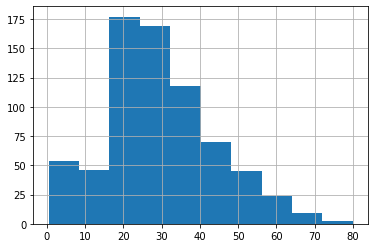

In [68]:
titanic_df['Age'].hist()

Cette distribution n'est ni uniforme ni normale. Il pourrait être intéressant de faire des catégories d'ages plutôt que d'afficher l'age directement. 

### 4.3.1) Intervalles égaux 

bins : nombre d'intervalle

=> adapté pour les distributions plutôt uniformes 

In [69]:
titanic_df['Age_bins']=pd.cut(titanic_df['Age'], bins=5)
titanic_df['Age_bins'].value_counts()

(16.336, 32.252]    346
(32.252, 48.168]    188
(0.34, 16.336]      100
(48.168, 64.084]     69
(64.084, 80.0]       11
Name: Age_bins, dtype: int64

### 4.3.2) Répartition par quartile 

In [73]:
titanic_df['Age_quantiles']=pd.qcut(titanic_df['Age'], q=5)
titanic_df['Age_quantiles'].value_counts()

(0.419, 19.0]    164
(31.8, 41.0]     144
(41.0, 80.0]     142
(19.0, 25.0]     137
(25.0, 31.8]     127
Name: Age_quantiles, dtype: int64

### 4.3.3) Répartition manuelle 

In [74]:
titanic_df['Age_manual']=pd.cut(titanic_df['Age'], bins=[0,13,21,30,50,90], 
                                labels = ['Child', 'Teen', 'Young', 'Mature', 'Senior'])
titanic_df['Age_manual'].value_counts()

Mature    241
Young     205
Teen      133
Child      71
Senior     64
Name: Age_manual, dtype: int64

## 4.4) Normaliser

A pour but de ramener toutes les valeurs à une échelle où elles peuvent être comparées. Dans cette partie je créerai des fonctions de normalisation dites robuste et standard. La fonction de normalisation robuste consiste à centrer les données sur la médiane (q2) et à uniformiser l'écart interquartile (q3-q1) qui deviendra l'unité. 

In [75]:
def robuste_scaling(dataset, column):
    
    q1 = dataset[column].quantile(0.25)
    q3 = dataset[column].quantile(0.75)
    
    diff = q3 - q2

    q2 = dataset[column].mean()
    
    dataset[column]=(dataset[column]-q2)/(diff)
    
    return dataset

def standard_scaling(dataset, column):
    
    mean = dataset[column].mean()
    std = dataset[column].std()
    dataset[column]=(dataset[column]-mean)/std
    
    return dataset